## CLIFF-SC Deconvolution of drug sensitivity

By slightly modifying CLIFF method and by linking it with the ouput of CLIMB-SC, we propose CLIFF-SC, a method providing drug sensitivity estimates at single-cell resolution (Fig. 6A, Methods, Supplemental Methods). CLIFF-SC computes viability prediction at single-cell resolution , using as input RNA expression of single cells and coefficients that CLIMB fits on every single cell. If the input dataset is composed of paired bulk RNA-seq and drug sensitivity screening data, a so-called bulk deconvolution at single-cell level is performed using a reference scRNA-seq dataset (cf. CLIMB-SC above).

In [ ]:
library(glmnet) ; library(ggplot2) ; library(reshape2)
library(CoreGx) ; library(PharmacoGx) ; library(climb)
library(sigmoid); library(ComplexHeatmap) ; library(circlize)
library(ggrepel); library(ggpmisc) ; library(infotheo)
library(Seurat) ; library(ggridges); library(RColorBrewer)
library(ggpubr) 

# We load CLIFF library
library(ClimbTheCliff)

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}

## Launch CLIFF-SC - CLIFF with single-cell resolution predictions

Compared with CLIFF, the fact of using the whole single-cell expression matrix increases drastically the computational burden. Thus, we ought to simplify CLIFF model as much as possible. We ex- plored multiple possibilities in order to do that. First, we run a linear model to perform a stringent gene selection. Second, we gather drug doses together within an AUC values, which reduce by D the computation required. Finally, we replace the EM algorithm with a simpler approach, where we use an estimate of the gradient of our loss function.

As opposed to CLIFF, we will use a mean square error between $y_n$ and $\hat{y}_n$, and uses selected gene G∗ instead of G. We also use drug sensitiv- ity summarized across doses as an area under the curve (AUC) values, y∗, normalized between 0.0 and 1.0 with a min-max normalization. This allows us to assume that yn∗ can be interpreted as a probability.

_Note: The following script takes a long time to run (around 6 hours)._

In [599]:
# We load the scRNA-seq as an ExpressionSet Object
sc.es = readRDS("data/cliff_sc/vanGalen_scRNA.RDS")
# We extract the normalized expression matrix from the ES object
mat.sc = exprs(sc.es)
colnames(mat.sc) = gsub("\\.", "-", colnames(mat.sc))
cell.types = factor(sc.es$cellType)

In [966]:
# 'Alphas' are single-cell 'proportions' as obtained with CLIMB-SC (normalized coefficients 
# fitted by CLIMB on single cells)
alphas = read.csv("data/cliff_sc/cliff-sc_alphas.csv",row.names=1, check.names=FALSE)
# We use pre-computed AUC values for our mixtures
auc_values = read.csv("data/cliff_sc/cliff-sc_drug_auc.csv", row.names=1, check.names=FALSE) 
# And the RNA expression of our mixtures 
bulk_samples = read.csv("data/cliff_sc/cliff-sc_bulk_expr.csv", row.names=1, check.names=FALSE)

In [1323]:
drug = 'Nilotinib'
y = as.numeric(as.character(auc_values[[drug]]))
y = (y - min(y)) / (max(y)-min(y)) # pre-computed AUC values for the drug, normalized between 0 and 1
fit <- glmnet(bulk_samples, y)
sel.genes = coef(fit)[-1,100] != 0

Therefore, for instance for Venetoclax, we will only use this subset of `sum(sel.genes)` (around 263 for Venetoclax) genes which got non-zero beta coefficients in the model solved by GLMNET, where a L1 regularization is applied.

In [1324]:
alpha = alphas[,1]
a = as.matrix(alphas)
X = t(mat.sc[sel.genes,])

In [1325]:
dim(X)

[1] 13468   322

We therefore subset our single-cell matrix to keep only these informative genes for following steps

In [1326]:
### CLIFF-SC METHOD ###
# Load CLIFF-SC functions 
sigmoid <- function(z){
   return( 1/(1+exp(-z)) )
}
do_ps <- function(X, betas){
    return( apply(X, 1, function(x) sigmoid(sum(x * betas))) )
}
do_ov_survival <- function(ps, alpha){
    sum(alpha * ps >= 0.5) / sum(alpha * ps > 0.0)
}
ms_err <- function(y, y_p)(
    return((1/length(y))*sum((y - y_p)^2))
)
custom_loss_given_betas <- function(betas, X, y, a){
    ps = do_ps(X, betas)
    # prediction of overall survival from individual probabilities
    y_pred = apply(a * ps, 2, sum) / apply(a, 2, sum)
    # return mean square error
    return( ms_err(y, y_pred) )
}
                  
# Initialize values
betas.0 = rep(0.0, dim(X)[2])
learning_rate = 0.1
ratio_mbatch = 0.1 # ratio of sample to include in mini-batches
size_mini_batch = round(dim(X)[1]*ratio_mbatch)
heps = .Machine$double.eps^(1/3)
all.betas = list()

# CLIFF-SC uses a Custom Gradient Descent with 100 steps
ptm <- proc.time()
for(i in 1:50) {
    message(i)
    # compute gradient at step i
    n <- length(betas.0)
    hh <- rep(0, n)
    gradient <- numeric(n)
    # We use mini-batches to accelerate the process 
    mini_batch = sample(1:dim(a)[2], 30, replace=FALSE)
    a.mbatch <- a[,mini_batch]
    y.mbatch <- y[mini_batch]
    # Iterate over genes to compute gene-specific derivative
    for(j in 1:n) {
        hh[j] <- heps
        # Numerical approximation of gradient for gene j
        gradient[j] <- (custom_loss_given_betas(betas.0 + hh, X=X, y=y.mbatch, a=a.mbatch) -
                        custom_loss_given_betas(betas.0 - hh, X=X, y=y.mbatch, a=a.mbatch)) / (2*heps)
        hh[j] <- 0
    }   
    # Update betas
    betas.0 = betas.0 - learning_rate*gradient
    all.betas[[i]] = betas.0
}
proc.time() - ptm

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50



     user    system   elapsed 
 7763.610  4690.468 14407.181 

In [1327]:
final_ps = do_ps(X, betas.0)
y_pred = apply(a * final_ps, 2, sum) / apply(a, 2, sum)
cor(y, y_pred)

[1] 0.267772

In [1328]:
df_coefs = data.frame(gene_name=colnames(X), cliff_coef=betas.0)

In [1329]:
# min-max normalization to clean results (optional)
final_ps.norm = 1 - (( final_ps - min(final_ps) ) / (max(final_ps) - min(final_ps)))
coord = data.frame(cbind(sc.es$UMAP1, sc.es$UMAP2))
colnames(coord) = c("UMAP1", "UMAP2")
rownames(coord) = colnames(sc.es)

In [1330]:
coord$Ps <- num(final_ps.norm)
coord$Ps[coord$Ps > quantile(coord$Ps,prob = 0.999)] <- quantile(coord$Ps,prob = 0.999)
coord$Ps[coord$Ps < quantile(coord$Ps,prob = 0.001)] <- quantile(coord$Ps,prob = 0.001)
coord$cell_type = sc.es$cellType
rownames(coord) = sc.es$cell_id

colnames(coord) = c('UMAP1', 'UMAP2', 'pi', 'cell_type')

write.csv(coord, paste0("data/cliff_sc/",drug,"_sc_drug_sens.csv"), quote=F)

### Load pre-processed results if needed 

We make available the tables used to compute figures of the manuscript than can be loaded to make the figures. The tables can be found there :
- `data/cliff_sc/A-674563_sc_drug_sens.csv`
- `data/cliff_sc/Foretinib_sc_drug_sens.csv`
- `data/cliff_sc/Nilotinib_sc_drug_sens.csv`
- `data/cliff_sc/Venetoclax_sc_drug_sens.csv`

In [1331]:
### Alternatively, one can load the pre-processed results ###
processed_table = "data/cliff_sc/Nilotinib_sc_drug_sens.csv"
coord = read.csv(processed_table, row.names = 'X')
head(coord)

,UMAP1,UMAP2,pi,cell_type
,<dbl>,<dbl>,<dbl>,<chr>
AML1012-D0_AAACGCTGGAAN,-3.119987,-2.06280287,0.2488601,GMP-like
AML1012-D0_AACAATGGTGTG,4.381665,-0.87978198,0.5190130,cDC-like
AML1012-D0_AACATTTAACAT,-2.933719,-1.33545012,0.2598845,GMP-like
AML1012-D0_AAGAGCCACTTC,1.417293,-0.04364914,0.3001822,cDC-like
AML1012-D0_AAGGTTTTTGAA,-2.601942,-3.43944486,0.2071299,GMP-like
AML1012-D0_AAGTGCACCAAT,4.224991,0.79209057,0.3415129,ProMono-like


In [1332]:
coord <- coord[order(abs(coord$pi - 0.5)),]
coord$cell_type = factor(coord$cell_type, levels = c("HSC-like", "Prog-like", "GMP-like", "cDC-like", "ProMono-like", "Mono-like"))

In [1333]:
g2 <- ggplot(data=coord)+
    geom_density_ridges_gradient( mapping=aes(x=num(pi),
                          y=cell_type, fill = stat(x),
                          height = ..density..), color='grey28', scale = 2.0, rel_min_height = 0.01) +
    xlim(c(0,1)) +
    scale_fill_gradientn(colors = rev(colorRampPalette(brewer.pal(n = 11, name = "RdYlBu"))(20))) +
    theme_minimal() + 
    xlab('Single-cell drug sensitivity') + ylab('') + #ggtitle("Summary at cell type level") +
    scale_y_discrete(expand = c(0.01, 0)) + #theme_joy() + 
    theme(legend.position = "none")

g1 <- ggplot(data=coord)+
    geom_point( mapping=aes(x=as.numeric(as.character(UMAP1)),
                            y=as.numeric(as.character(UMAP2)),
                            color=pi),
                size = 0.5, alpha = 0.8) +
    theme_classic() + 
    xlab('') + ylab('') + #ggtitle("Venetoclax single-cell survival probability") +
    scale_color_gradientn(colors = rev(colorRampPalette(brewer.pal(n = 7, name = "RdYlBu"))(100)), 
                          breaks = waiver(), #values = rev(c(1.0,0.7,0.5,0.4,0.25,0.0))
                          space = "Lab")

options(repr.plot.width = 7, repr.plot.height = 3,repr.plot.res = 200, dpi=300)
g_arr <- ggarrange(g1, g2, ncol=2)

Picking joint bandwidth of 0.0229



pdf 
  2

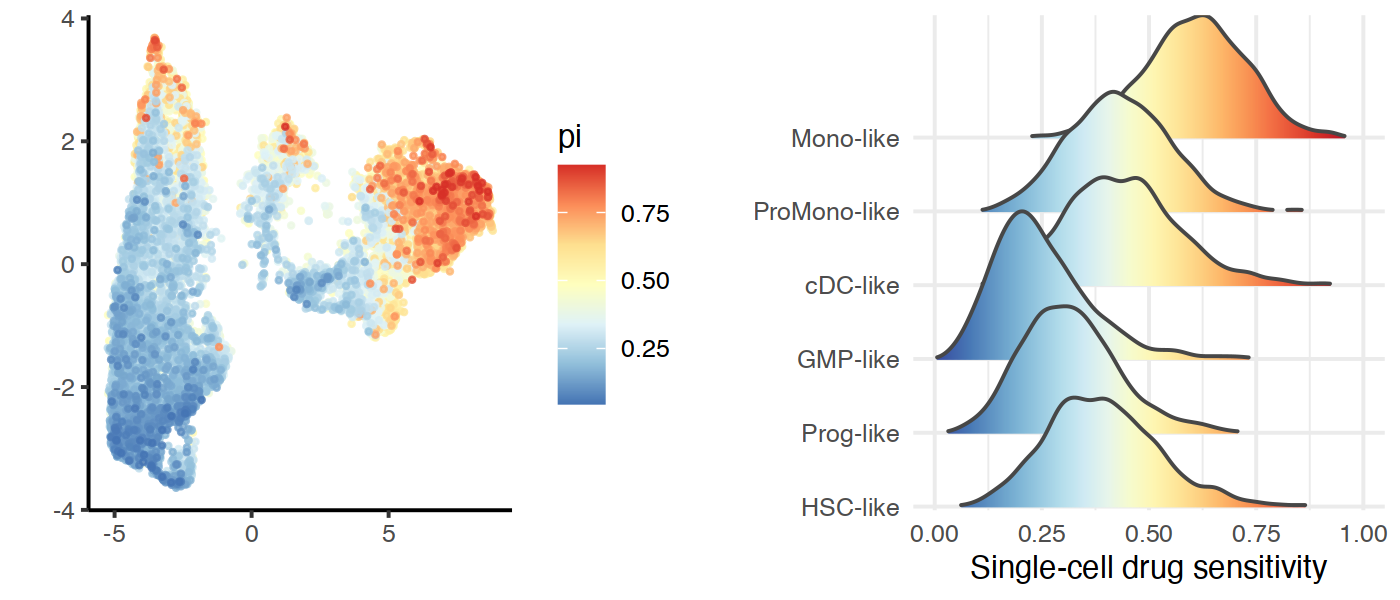

In [1334]:
pdf('results/fig7/Nilotinib_single_cell_drug_sensitivity.pdf', width=7, height=3) ; g_arr ; dev.off()
g_arr

In [1276]:
agg_cliff_sc = aggregate(coord$pi, list(coord$cell_type), mean)

PI_beataml = read.csv('results/fig6/tab_all_drugs/PI_ A-674563 .csv', row.names='X')
PI_beataml = colMeans(PI_beataml[,grepl('like', colnames(PI_beataml))])

names(PI_beataml) = gsub('\\.', '-', names(PI_beataml))

`geom_smooth()` using formula = 'y ~ x'


pdf 
  2

`geom_smooth()` using formula = 'y ~ x'


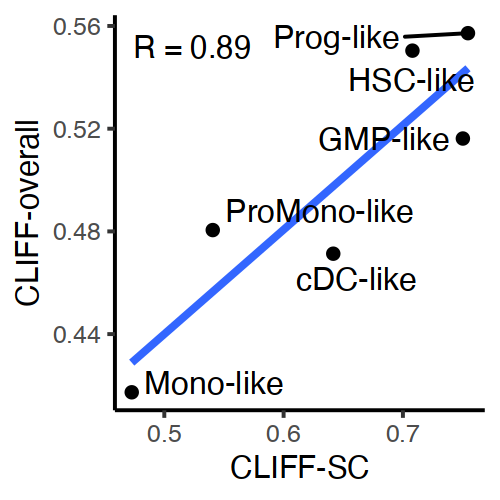

In [1277]:
options(repr.plot.width = 2.5, repr.plot.height = 2.5,repr.plot.res = 200, dpi=300)
df_cliff_comp = data.frame(celltype=agg_cliff_sc$`Group.1`, cliff_sc = agg_cliff_sc$x, cliff_overall=PI_beataml[match(agg_cliff_sc$`Group.1`, names(PI_beataml))])
g3 <- ggplot(df_cliff_comp, aes(x=cliff_sc, y=cliff_overall)) + 
    geom_smooth(method = "lm", se=F) + stat_correlation() + 
    geom_point() + theme_classic() +
    xlab('CLIFF-SC') + ylab('CLIFF-overall') + geom_text_repel(aes(label=celltype), size=4)
pdf('results/fig7/ A-674563_single_cell_drug_sensitivity.pdf', width=2.5, height=2.5) ; g3 ; dev.off()
g3

In [1278]:
#df_cliff_comp_A674563 = df_cliff_comp
#df_cliff_comp_A674563$drug = 'A-674563'
#df_cliff_comp_Foretinib = df_cliff_comp
#df_cliff_comp_Foretinib$drug = 'Foretinib'
#df_cliff_comp_venetoclax = df_cliff_comp
#df_cliff_comp_venetoclax$drug = 'Venetoclax'

#df_melt = rbind(df_cliff_comp_A674563, df_cliff_comp_venetoclax, df_cliff_comp_Foretinib)
#write.csv(df_melt, 'results/fig7/scatter_plot_3drugs_CLIFF.csv', quote=F)

In [1285]:
# load data of 3 drugs 
df_melt = read.csv('results/fig7/scatter_plot_3drugs_CLIFF.csv')

`geom_smooth()` using formula = 'y ~ x'


pdf 
  2

`geom_smooth()` using formula = 'y ~ x'


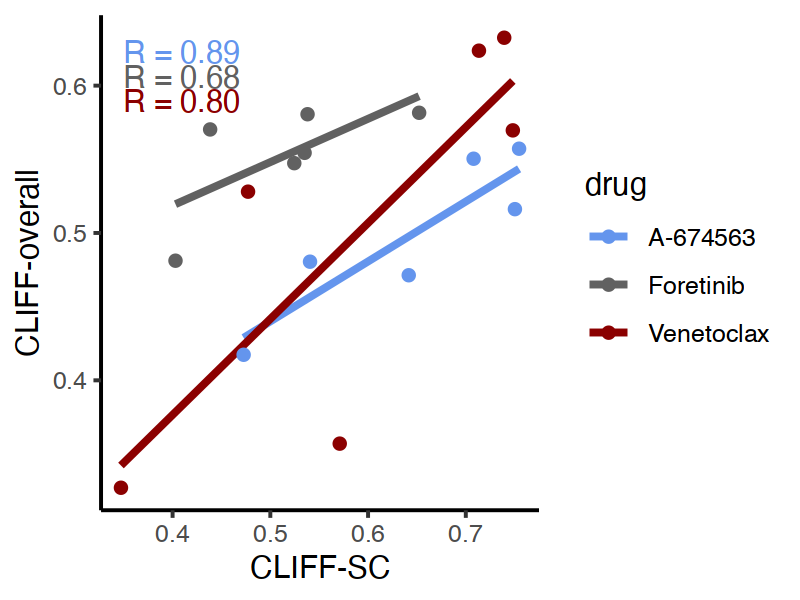

In [1301]:
options(repr.plot.width = 4, repr.plot.height = 3.,repr.plot.res = 200, dpi=300)
df_cliff_comp = data.frame(celltype=agg_cliff_sc$`Group.1`, cliff_sc = agg_cliff_sc$x, cliff_overall=PI_beataml[match(agg_cliff_sc$`Group.1`, names(PI_beataml))])
g3 <- ggplot(df_melt, aes(x=cliff_sc, y=cliff_overall, color=drug)) + 
    geom_smooth(method = "lm", se=F) + stat_correlation() + 
    scale_color_manual(values = c('cornflowerblue', 'grey38', 'darkred')) +
    geom_point() + theme_classic() +
    xlab('CLIFF-SC') + ylab('CLIFF-overall') #+ geom_text_repel(aes(label=celltype), size=4)
pdf('results/fig7/3drugs_single_cell_drug_sensitivity.pdf', width=4, height=3) ; g3 ; dev.off()
g3

## Look at HSC-like drug sensitivity

In [1165]:
coord = coord[sc.es$cell_id,]

In [1166]:
all(coord$UMAP1 == sc.es$UMAP1)
# We add to the ExpressionSet object the information about single-cell sensitivity
sc.es$pi_norm = coord$pi # final_ps # Add infered single-cell sensitivity to object

[1] TRUE

In [1206]:
# We create an object that contains only HSC-like cell-type and we define resistant/sensitive populations
sc.es.hsclike = sc.es[,as.character(sc.es$cellType) == 'HSC-like']

sel_sensitive = sc.es.hsclike$pi_norm > quantile(sc.es.hsclike$pi_norm, p=0.9)
sel_resistant = sc.es.hsclike$pi_norm <= quantile(sc.es.hsclike$pi_norm, p=0.1)

sc.es.hsclike$cell_type2 = as.character(sc.es.hsclike$cellType)
sc.es.hsclike$cell_type2[sel_resistant] = 'HSC-like_resistant'
sc.es.hsclike$cell_type2[sel_sensitive] = 'HSC-like_sensitive'
sc.es.hsclike$cell_type2 = factor(sc.es.hsclike$cell_type2, levels = unique(sc.es.hsclike$cell_type2))

In [1207]:
# We create a Seurat object
srt.hsclike = CreateSeuratObject(exprs(sc.es.hsclike), project = "SeuratProject", assay = "RNA")
# We trick Seurat by putting resistant/sensitivity category as cell types
srt.hsclike$cell_type = sc.es.hsclike$cell_type2
Idents(srt.hsclike)  = srt.hsclike$cell_type

In [1208]:
# Find differentially expressed features between CD14+ and FCGR3A+ Monocytes
de.markers <- FindMarkers(srt.hsclike, ident.1 = "HSC-like_sensitive", ident.2 = "HSC-like_resistant",
                          logfc.threshold=0, max.cells.per.ident=20, test.use='wilcox')

In [1209]:
head(de.markers, 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187653,2.991982e-08,-1.4658768,0.041,0.887,0.000129852
NPM1,2.354020e-06,1.0569453,0.990,0.397,0.010216446
ANXA1,2.427600e-05,-1.3322812,0.124,0.851,0.105357855
FTH1,7.655992e-05,-0.5662107,0.371,0.716,0.332270034
RPS12,1.609813e-04,0.2826074,1.000,0.985,0.698659014
PRPF40A,1.740999e-04,0.2953168,0.407,0.216,0.755593504
ACTB,2.136401e-04,-0.5236210,0.474,0.758,0.927197863
VIM,2.715939e-04,-0.7963556,0.330,0.711,1.000000000
CAP1,7.171827e-04,-0.7535091,0.211,0.644,1.000000000


In [1215]:
de.markers$labels = rownames(de.markers)
de.markers$labels[-log10(de.markers$p_val) < 4] <- ''
#de.markers$labels[!grepl("NPM1",de.markers$labels)] <- ''
de.markers$colors = 'black'
de.markers$colors[-log10(de.markers$p_val) > 1.3] <- 'red'

pdf 
  2

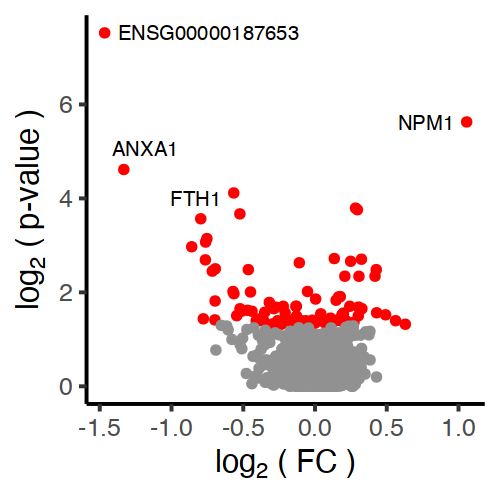

In [1221]:
options(repr.plot.width=2.5, repr.plot.height=2.5)
g = ggplot(de.markers) + geom_point(aes(y=-log10(p_val), x=avg_log2FC, color=colors), size=1) + theme_classic() + 
    scale_color_manual(values=c('grey57', 'red'), guide = "none") +
    geom_text_repel(aes(y=-log10(p_val), x=avg_log2FC, label=labels), size=2.5) + 
    xlab(expression(paste(log[2],' ( FC )'))) + ylab(expression(paste(log[2],' ( p-value )')))
pdf('results/fig7/Venetoclax_DE_analysis_25up_25_down_NPM1.pdf', width=2.5, height=2.5) ; g ; dev.off()
g

No id variables; using all as measure variables



pdf 
  2

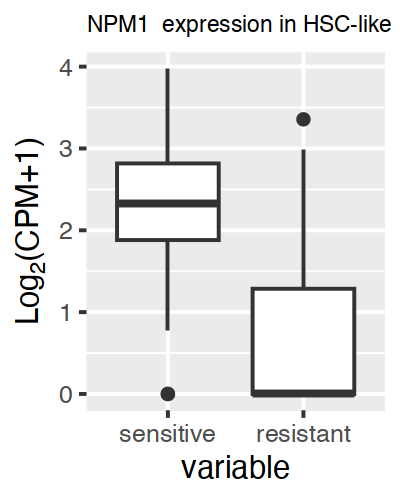

In [1249]:
## Plot the expression of DE genes in two groups of HSC-like cells segregated by predicted venetoclax sensitivity
# main DE genes : NPM1 , ENSG00000187653 , ANXA1 , VIM, RPS12, PRPF40A, EEF1B2
gene='NPM1'
df_de = data.frame(sensitive=exprs(sc.es.hsclike[,sel_sensitive])[gene,], 
                   resistant=exprs(sc.es.hsclike[,sel_resistant])[gene,])
df_de_m = melt(df_de)
g <- ggplot(df_de_m, aes(x=variable, y=value)) + geom_boxplot() + ylab(expression(paste(Log[2], '(CPM+1)'))) +
    ggtitle(paste(gene, ' expression in HSC-like')) + theme(plot.title = element_text(size = 8))
options(repr.plot.width=2, repr.plot.height=2.5)
pdf(paste0('results/fig7/Venetoclax_DE_analysis_25up_25_down_',gene,'_expression.pdf'), width=2, height=2.5) ; g ; dev.off()
g